In [1]:
# import

import torch.nn.functional as F
import requests
import random
import torch
import matplotlib.pyplot as plt

In [2]:
# dataset download

names = requests.get("https://raw.githubusercontent.com/karpathy/makemore/master/names.txt").text.splitlines()

In [3]:
# string to token conversion

itos = ['.'] + sorted(list(set("".join(names))))
stoi = {ch: idx for idx, ch in enumerate(itos)}

In [4]:
# create dataset

def create_data(words, block_size=3):
    xs = []
    ys = []
    for word in words:
        window = [0] * block_size
        word += "."
        for char in word:
            xs.append(window)
            ys.append(stoi[char])

            window = window[1:]
            window.append(stoi[char])
    return torch.tensor(xs), torch.tensor(ys)

In [5]:
# initialize hyperparameters

emb_dim = 10
block_size = 3
hidden_layer_dim = 100
emb_size = emb_dim * block_size  # don't change this

In [6]:
# initialize train, val, test datasets

random.seed(17)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))
xs, ys = create_data(names, block_size)
x_train, y_train = create_data(names[:n1], block_size)
x_val, y_val = create_data(names[n1:n2], block_size)
x_test, y_test = create_data(names[n2:], block_size)

print("train -", x_train.shape[0])
print("val   -", x_val.shape[0])
print("test  -", x_test.shape[0])
print("total -", xs.shape[0])

train - 182705
val   - 22652
test  - 22789
total - 228146


In [7]:
# initialize model weights

g = torch.Generator().manual_seed(2147483647)
emb = torch.randn((27, emb_dim), generator=g)
w1 = torch.randn((emb_size, hidden_layer_dim), generator=g) * ((5/3)/(emb_size**0.5))
# b1 = torch.randn(hidden_layer_dim, generator=g) * 0.0

bn_scale = torch.ones((1, hidden_layer_dim))
bn_shift = torch.zeros((1, hidden_layer_dim))

w2 = torch.randn((hidden_layer_dim, 27), generator=g) * ((5/3)/(hidden_layer_dim**0.5))
b2 = torch.randn(27, generator=g) * 0.0

params = [emb, w1, bn_scale, bn_shift, w2, b2]

bn_running_mean = torch.zeros((1, hidden_layer_dim))
bn_running_std = torch.ones((1, hidden_layer_dim))

for param in params:
    param.requires_grad = True
    # param.retain_grad = True
params_count = sum([p.nelement() for p in params])
print(f"{params_count=}")

params_count=6197


In [8]:
## training loop ##

batch_size = 128
lossi = []
for i in range(200001):

    # creating batch
    ix = torch.randint(0, x_train.shape[0], (batch_size,))

    ## forward pass ##
    embs = emb[x_train[ix]]
    preact = embs.view(-1, emb_size) @ w1 #+ b1

    # batch-norm
    bn_mean_i = preact.mean(0, keepdim=True)
    bn_std_i = preact.std(0, keepdim=True)
    preact = bn_scale * ((preact - bn_mean_i) / bn_std_i) + bn_shift

    # bn buffer update
    with torch.no_grad():
        bn_running_mean = 0.999 * bn_running_mean + 0.001 * bn_mean_i
        bn_running_std = 0.999 * bn_running_std + 0.001 * bn_std_i

    act = torch.tanh(preact)
    logits = act @ w2 + b2

    loss = F.cross_entropy(logits, y_train[ix])  # softmax (final activation) + avg neg log likelihood loss
    lossi.append(loss.item())

    # print loss
    if i % 10000 == 0:
        print(f"{i}/200000", "-", round(loss.item(), 4))

    ## backward pass ##
    for param in params:
        param.grad = None
    loss.backward()

    ## update parameters ##
    lr = 0.1 if i < 150000 else 0.01
    # lr = 0.1
    for param in params:
        param.data += -lr * param.grad

    # break

0/200000 - 3.8767
10000/200000 - 2.2672
20000/200000 - 2.379
30000/200000 - 2.1238
40000/200000 - 2.0596
50000/200000 - 2.123
60000/200000 - 2.186
70000/200000 - 2.066
80000/200000 - 2.1643
90000/200000 - 2.0924
100000/200000 - 2.1149
110000/200000 - 2.1768
120000/200000 - 2.2093
130000/200000 - 2.0433
140000/200000 - 2.044
150000/200000 - 1.984
160000/200000 - 2.1308
170000/200000 - 2.2371
180000/200000 - 2.0694
190000/200000 - 2.1502
200000/200000 - 2.0955


In [9]:
lossi = lossi[:-1]
average_lossi = torch.tensor(lossi).view(-1, 1000).mean(1).tolist()

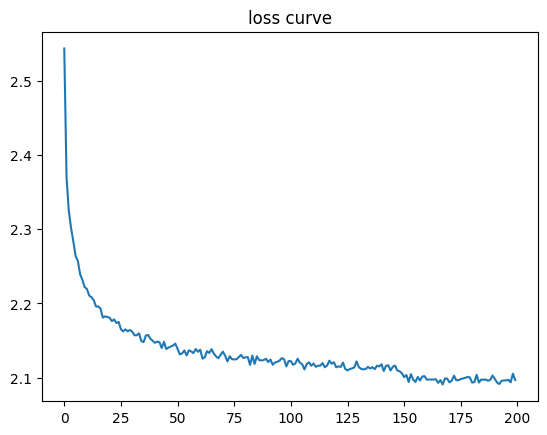

In [16]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.title("loss curve");

In [11]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "all": (xs, ys),
        "train": (x_train, y_train),
        "val": (x_val, y_val),
        "test": (x_test, y_test)
    }[split]
    embs = emb[x]
    preact = embs.view(-1, emb_size) @ w1
    preact = bn_scale * ((preact - bn_running_mean) / bn_running_std) + bn_shift
    act = torch.tanh(preact)
    logits = act @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, "-", loss.item())

In [12]:
split_loss("val")
split_loss("all")
split_loss("test")

val - 2.1527459621429443
all - 2.0934929847717285
test - 2.126413345336914


In [13]:
# inference

for _ in range(20):
    xt = [0] * block_size
    while True:
        with torch.no_grad():
            embs = emb[xt]
            preact = embs.view(-1, emb_size) @ w1
            preact = bn_scale * ((preact - bn_running_mean) / bn_running_std) + bn_shift
            act = torch.tanh(preact)
            logits = act @ w2 + b2
            counts = logits.exp()
            probs = counts / counts.sum(1, keepdim=True)
            next_idx = torch.multinomial(probs, num_samples=1, replacement=True)[0].item()
            xt = xt[1:] + [next_idx]
            print(itos[next_idx], end="")
            if next_idx == 0:
                print("")
                break

ki.
kaire.
son.
zonier.
halorshevalayt.
keila.
ladeevy.
islieana.
aiyan.
adiannaeviel.
jeighithap.
galion.
jaylenne.
olena.
mela.
lokristyn.
kha.
aum.
dra.
clam.


#### Analysing the distribution of logits and activations after kaiming initialization using toy input examples and weight matricies.

In [17]:
gg = torch.Generator().manual_seed(10101010)
x = torch.randn((32, 30), generator=gg)
w1_ = torch.randn((30, 100), generator=gg) * ((5/3)/(30**0.5)) # scaling the weigths using kaiming initialization
y1 = x @ w1_
act1 = torch.tanh(y1)

w2_ = torch.randn((100, 100), generator=gg) * ((5/3)/(100**0.5))
y2 = act1 @ w2_
act2 = torch.tanh(y2)

w3 = torch.randn((100, 100), generator=gg) * ((5/3)/(100**0.5))
y3 = act2 @ w3
act3 = torch.tanh(y3)

w4 = torch.randn((100, 100), generator=gg) * ((5/3)/(100**0.5))
y4 = act3 @ w4
act4 = torch.tanh(y4)

w5 = torch.randn((100, 100), generator=gg) * ((5/3)/(100**0.5))
y5 = act4 @ w5
act5 = torch.tanh(y5)

In [19]:
print("       mean           std")
print("      ------------------------------")
print("y1   |", y1.mean(), y1.std())
print("act1 |", act1.mean(), act1.std())
print("y2   |", y2.mean(), y2.std())
print("act2 |", act2.mean(), act2.std())
print("y3   |", y3.mean(), y3.std())
print("act3 |", act3.mean(), act3.std())
print("y4   |", y4.mean(), y4.std())
print("act4 |", act4.mean(), act4.std())
print("y5   |", y5.mean(), y5.std())
print("act5 |", act5.mean(), act5.std())

       mean           std
      ------------------------------
y1   | tensor(0.0231) tensor(1.7516)
act1 | tensor(0.0147) tensor(0.7628)
y2   | tensor(0.0204) tensor(1.3336)
act2 | tensor(0.0081) tensor(0.7094)
y3   | tensor(0.0067) tensor(1.2223)
act3 | tensor(0.0018) tensor(0.6831)
y4   | tensor(0.0048) tensor(1.1256)
act4 | tensor(0.0066) tensor(0.6637)
y5   | tensor(-0.0070) tensor(1.0922)
act5 | tensor(-0.0050) tensor(0.6553)


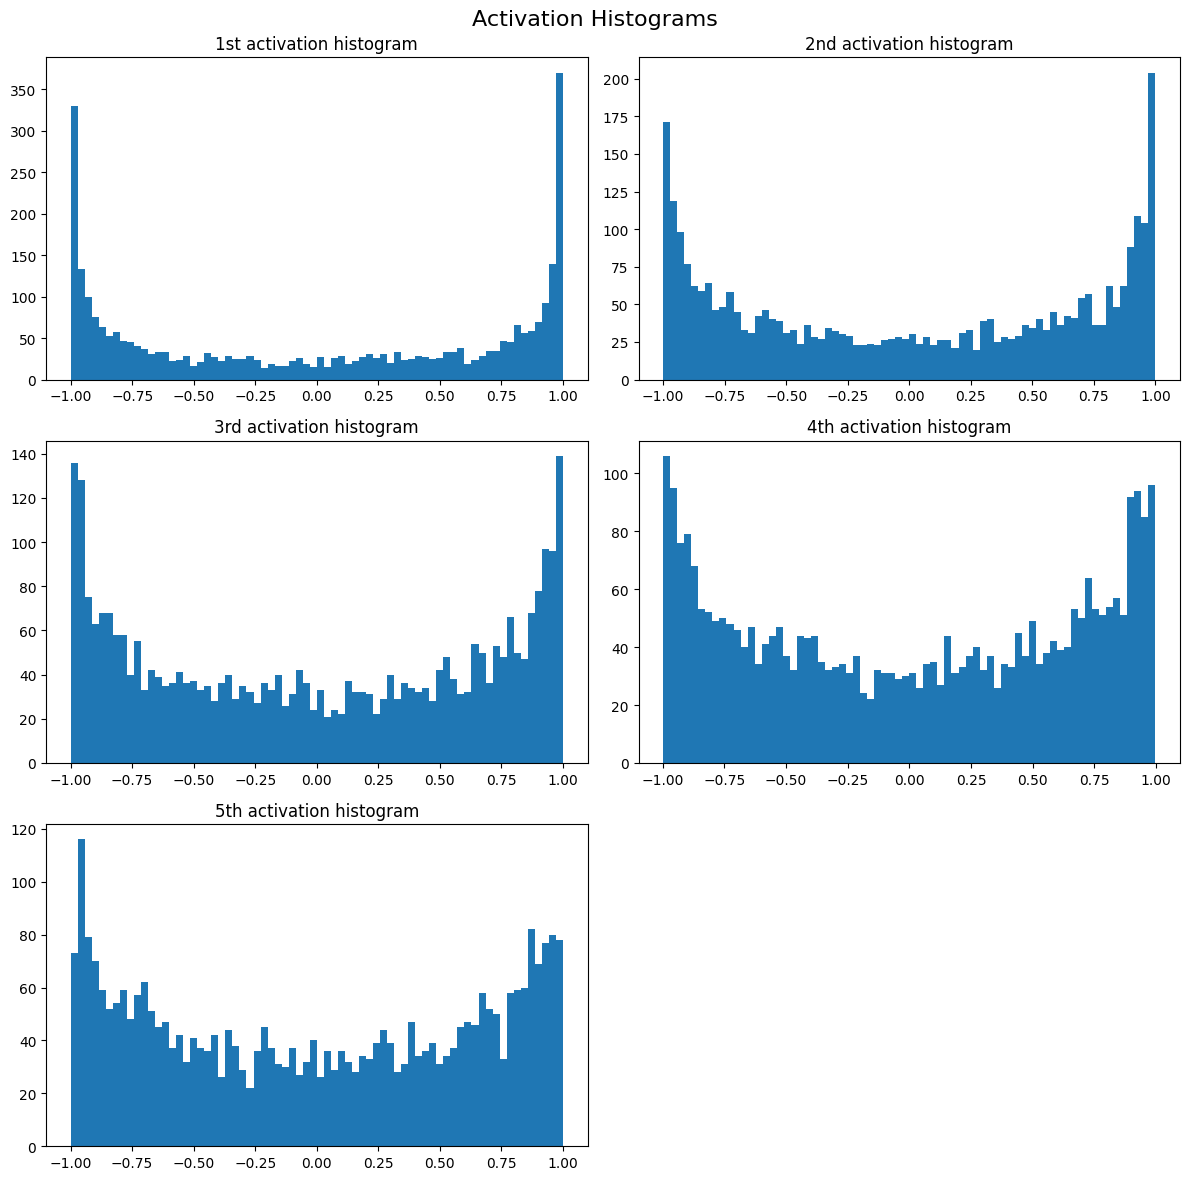

In [51]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle("Activation Histograms", fontsize=16)

axs[0, 0].hist(act1.view(-1).tolist(), 70)
axs[0, 0].set_title("1st activation histogram")

axs[0, 1].hist(act2.view(-1).tolist(), 70)
axs[0, 1].set_title("2nd activation histogram")

axs[1, 0].hist(act3.view(-1).tolist(), 70)
axs[1, 0].set_title("3rd activation histogram")

axs[1, 1].hist(act4.view(-1).tolist(), 70)
axs[1, 1].set_title("4th activation histogram")

axs[2, 0].hist(act5.view(-1).tolist(), 70)
axs[2, 0].set_title("5th activation histogram")

# Remove the unused subplot
fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

the tanh activations consecutively take smaller values because of the squashing nature of the function.

#### Pytorchifying the MLP

In [62]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros((1, fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias == None else [self.bias])


class BatchNorm1D:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps # to avoid division by zero when variance is zero
        self.momentum = momentum # the fraction of running mean and variance to be updated with new batch mean and variance
        self.training = True # bn has different training and inference behaviour

        # trainable parameters (trained with gradient update)
        self.gamma = torch.ones(dim) # scaling parameter, init with ones because it is multiplied with normalized preactivations
        self.beta = torch.zeros(dim) # shifting parameter, init with zeros because it is added with normalized preactivations

        # buffers (trained with a running 'momentum update)
        self.running_mean = torch.zeros(dim) # init with zero because it is subtracted from the preact values
        self.running_var = torch.ones(dim) # init with ones because it is the denominator of the preact values

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to zero mean and unit standard deviation
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:

    def __init__(self, fan_in, fan_out):
        self.W = torch.randn((fan_in, fan_out))

    def __call__(self, x):
        self.out = self.W[x]
        return self.out

    def parameters(self):
        return [self.W]


class Sequential:

    def __init__(self, layers):
        self.layers = layers
        self.parameters = [p for layer in self.layers for p in layer.parameters()]
        for p in self.parameters:
            p.requires_grad = True

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out


class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

In [72]:
# for reproducibility
torch.manual_seed(100)

# hyperparameters
n_embd = 10
n_hidden = 100
vocab_size = 27

# model definition
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1D(vocab_size)
])

# WITHOUT BATCHNORM
# model = Sequential([
#     Embedding(vocab_size, n_embd),
#     Flatten(),
#     Linear(n_embd * block_size, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, vocab_size)
# ])

# scaling of weights for better gradient propagation
with torch.no_grad():
    model.layers[-1].gamma *= 0.1 # last layer : make less confident
    for layer in model.layers[:-1]: # all other layers : apply gain
        if isinstance(layer, Linear):
            layer.weight *= 5/3

In [73]:
max_steps = 200001
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = x_train[ix], y_train[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for layer in model.layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph

  for p in model.parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in model.parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters])

  if i >= 1:
    break # for visualizing activations, gradients

      0/ 200001: 3.2888


layer 4 (      Tanh): mean -0.00, std 0.62, saturated: 3.53%
layer 7 (      Tanh): mean -0.00, std 0.63, saturated: 3.31%
layer 10 (      Tanh): mean -0.00, std 0.63, saturated: 2.69%
layer 13 (      Tanh): mean -0.00, std 0.63, saturated: 3.22%
layer 16 (      Tanh): mean +0.00, std 0.64, saturated: 2.75%


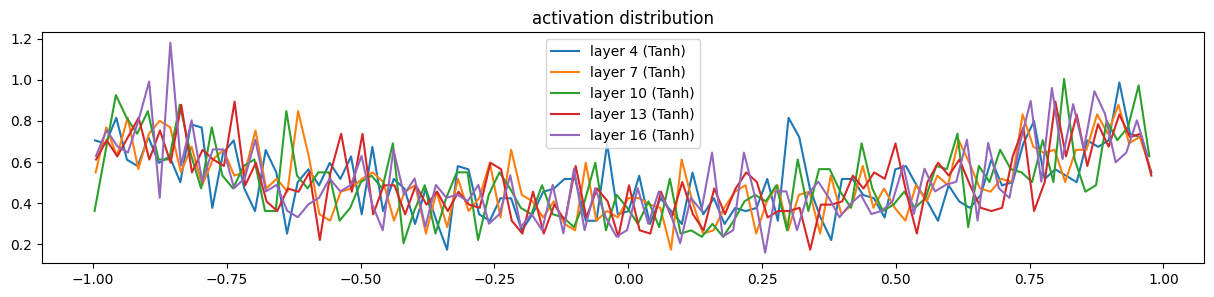

In [74]:
# visualize histograms
plt.figure(figsize=(15, 3)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

layer 4 (      Tanh): mean -0.000000, std 1.142226e-03
layer 7 (      Tanh): mean +0.000000, std 9.061794e-04
layer 10 (      Tanh): mean +0.000000, std 7.672884e-04
layer 13 (      Tanh): mean +0.000000, std 6.462972e-04
layer 16 (      Tanh): mean +0.000000, std 5.716324e-04


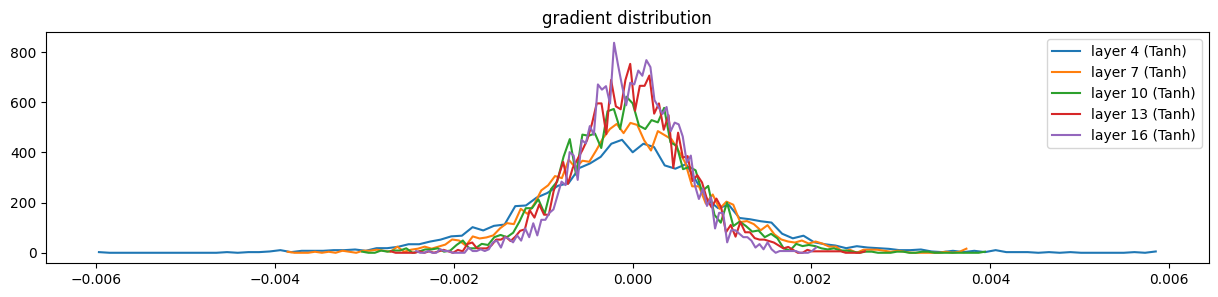

In [75]:
# visualize histograms
plt.figure(figsize=(15, 3)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean -0.000000 | std 2.243157e-03 | grad:data ratio 2.283155e-03
weight  (30, 100) | mean +0.000121 | std 3.015655e-03 | grad:data ratio 9.842150e-03
weight (100, 100) | mean -0.000012 | std 2.625573e-03 | grad:data ratio 1.578097e-02
weight (100, 100) | mean +0.000027 | std 2.053768e-03 | grad:data ratio 1.225792e-02
weight (100, 100) | mean +0.000029 | std 1.786596e-03 | grad:data ratio 1.073079e-02
weight (100, 100) | mean -0.000023 | std 1.501903e-03 | grad:data ratio 9.062559e-03
weight  (100, 27) | mean +0.000002 | std 2.603205e-03 | grad:data ratio 1.569967e-02


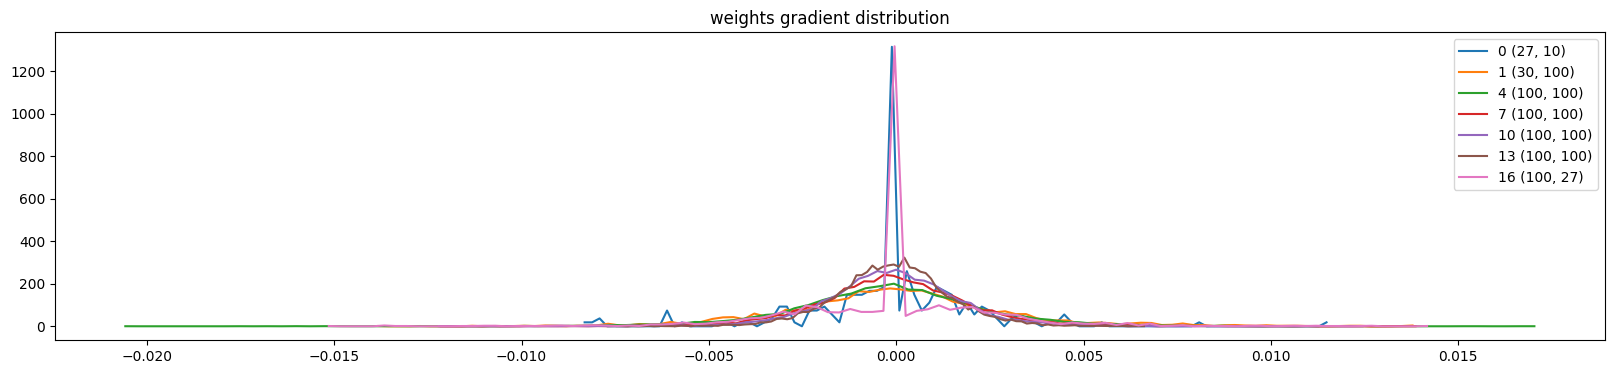

In [76]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model.parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [77]:
len(ud[0])

19

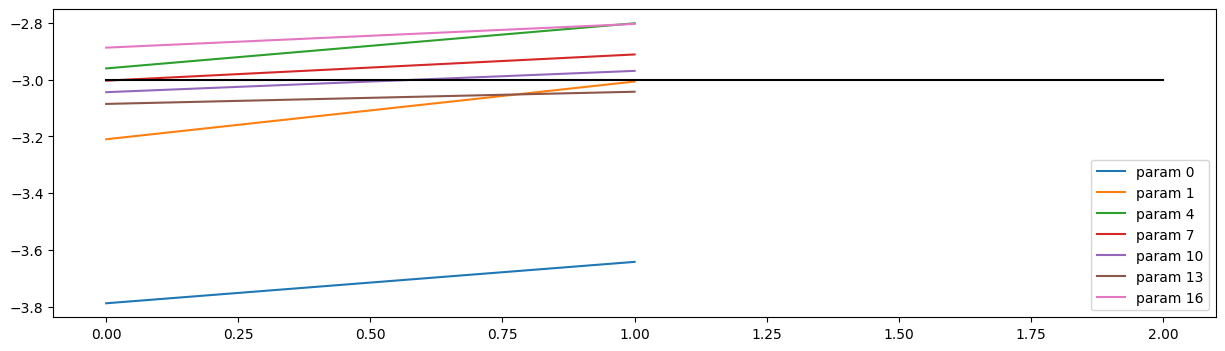

In [78]:
plt.figure(figsize=(15, 4))
legends = []
for i,p in enumerate(model.parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

BONUS Content

In [ ]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):

  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

In [ ]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

In [ ]:
g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())